In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as scs
import geopandas


pd.options.display.max_columns = None

ImportError: dlopen(/anaconda3/lib/python3.6/site-packages/fiona/ogrext.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libgif.7.dylib
  Referenced from: /anaconda3/lib/libgdal.20.dylib
  Reason: image not found

In [10]:
#data for 2017 begins in June
#using 2018-2019 data
trips = pd.read_csv("data/2018-2019-fordgobike-tripdata.csv")
weather = pd.read_csv('data/weather.csv')

In [11]:



def feature_addition(df):
    '''
    INPUT dataframe
    OUTPUT dataframe with extra features
    '''
    #create a new column that shows the day of week for each trip
    #need to transform panda series to datetime
    #before we can use .dt.dayofweek
    #monday = 0 and sunday = 6

    df.start_time = pd.to_datetime(df.start_time)

    df['day_of_week'] = df.start_time.dt.dayofweek

    df['date'] = df.start_time.dt.date
    df['year'] = df.start_time.dt.year
    df['month'] = df.start_time.dt.month
    df['day'] = df.start_time.dt.day
    df['hour'] = df.start_time.dt.hour

    #any trip with less than 90 seconds and where
    #start station IS the end station,
    #we make the assumption that its malfunctioned
    df['malfunction'] = (df.duration_sec < 90) & (df.start_station_name == df.end_station_name)
    df['age'] = 2019 - df.member_birth_year

    return df

def num_malfunctions(df):
    '''
    INPUT: Dataframe with a "malfunction" column
    Sum the number of malfunctions up
    OUTPUT: Tuple with 
            first element as number of malfunctions and
            second element as number of non-malfunctions
    '''

    num_malfunctions = df.malfunction.sum()
    num_working = len(df.malfunction) - num_malfunctions

    return (num_malfunctions, num_working)

def frequent_malfunction(df):
    return df.bike_id[df.malfunction == True].value_counts()

def same_station(df):
    return df.bike_id[df.start_station_name == df.end_station_name].value_counts()

def model_city(df, city = 1):
    '''
    Breaks the dataset into 3 cities
    SF = 1
    OAK = 2
    SJ = 3

    INPUT: Dataframe
           Number for city to be modeled
    OUTPUT: returns a portion of the original dataframe
    ''' 
    if city == 1:
        return df[(df.end_station_latitude > 37.697799) & (df.end_station_longitude <-122.330676)]
    elif city == 2:
        return df[(df.end_station_latitude > 37.697799) & (df.end_station_longitude >-122.330676)]
    elif city == 3:
        return df[df.end_station_latitude < 37.697799]


def get_dummies(df):
    
    #start station dummies
    start_dummies = pd.get_dummies(df.start_station_name)
    #end station dummies
    end_dummies = pd.get_dummies(df.end_station_name)
    df = pd.concat([df,start_dummies], axis=1)
    df = pd.concat([df,end_dummies], axis=1)
    
    return df

def merge_dfs(df1, df2, column = 'date'):
    '''
    INPUT df1 is the trips dataframe
          df2 is the weather dataframe
    OUTPUT 1 combined dataframe
    '''
    df2['tavg'] = (df2.tmax + df2.tmin)/2
    df2[column] = pd.to_datetime(df2[column])
    df2[column] = df2[column].dt.date
    combined_df = pd.merge(df1,df2, on='date', how='left')
    return combined_df




In [12]:
df = feature_addition(trips)

In [13]:
df[df.start_station_id != df.end_station_id]

,Unnamed: 0,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,day_of_week,date,year,month,day,hour,malfunction,age
0,0,75284,2018-01-31 22:52:35.239,2018-02-01 19:47:19.8240,120.0,Mission Dolores Park,37.761420,-122.426435,285.0,Webster St at O'Farrell St,37.783521,-122.431158,2765,Subscriber,1986.0,Male,No,2,2018-01-31,2018,1,31,22,False,33.0
2,2,71576,2018-01-31 14:23:55.889,2018-02-01 10:16:52.1160,304.0,Jackson St at 5th St,37.348759,-121.894798,296.0,5th St at Virginia St,37.325998,-121.877120,3039,Customer,1996.0,Male,No,2,2018-01-31,2018,1,31,14,False,23.0
3,3,61076,2018-01-31 14:53:23.562,2018-02-01 07:51:20.5000,75.0,Market St at Franklin St,37.773793,-122.421239,47.0,4th St at Harrison St,37.780955,-122.399749,321,Customer,NaN,NaN,No,2,2018-01-31,2018,1,31,14,False,NaN
4,4,39966,2018-01-31 19:52:24.667,2018-02-01 06:58:31.0530,74.0,Laguna St at Hayes St,37.776435,-122.426244,19.0,Post St at Kearny St,37.788975,-122.403452,617,Subscriber,1991.0,Male,No,2,2018-01-31,2018,1,31,19,False,28.0
5,5,6477,2018-01-31 22:58:44.867,2018-02-01 00:46:41.9080,236.0,Market St at 8th St,37.803686,-122.282497,160.0,West Oakland BART Station,37.805318,-122.294837,1306,Customer,NaN,NaN,No,2,2018-01-31,2018,1,31,22,False,NaN
6,6,453,2018-01-31 23:53:53.632,2018-02-01 00:01:26.8050,110.0,17th & Folsom Street Park (17th St at Folsom St),37.763708,-122.415204,134.0,Valencia St at 24th St,37.752428,-122.420628,3571,Subscriber,1988.0,Male,No,2,2018-01-31,2018,1,31,23,False,31.0
7,7,180,2018-01-31 23:52:09.903,2018-01-31 23:55:10.8070,81.0,Berry St at 4th St,37.775880,-122.393170,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,1403,Subscriber,1980.0,Male,No,2,2018-01-31,2018,1,31,23,False,39.0
8,8,996,2018-01-31 23:34:56.004,2018-01-31 23:51:32.6740,134.0,Valencia St at 24th St,37.752428,-122.420628,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,3675,Subscriber,1987.0,Male,Yes,2,2018-01-31,2018,1,31,23,False,32.0
9,9,825,2018-01-31 23:34:14.027,2018-01-31 23:47:59.8090,305.0,Ryland Park,37.342725,-121.895617,317.0,San Salvador St at 9th St,37.333955,-121.877349,1453,Subscriber,1994.0,Female,Yes,2,2018-01-31,2018,1,31,23,False,25.0
10,10,1316,2018-01-31 23:24:00.416,2018-01-31 23:45:56.8240,98.0,Valencia St at 16th St,37.765052,-122.421866,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,1278,Customer,NaN,NaN,No,2,2018-01-31,2018,1,31,23,False,NaN


In [14]:
sf = model_city(df,1).reset_index()
sf.drop(['index'], axis = 1, inplace = True)
weather.columns = map(str.lower, weather.columns)

In [15]:
sf.head(2)

,Unnamed: 0,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,day_of_week,date,year,month,day,hour,malfunction,age
0,0,75284,2018-01-31 22:52:35.239,2018-02-01 19:47:19.8240,120.0,Mission Dolores Park,37.761420,-122.426435,285.0,Webster St at O'Farrell St,37.783521,-122.431158,2765,Subscriber,1986.0,Male,No,2,2018-01-31,2018,1,31,22,False,33.0
1,1,85422,2018-01-31 16:13:34.351,2018-02-01 15:57:17.3100,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,2815,Customer,NaN,NaN,No,2,2018-01-31,2018,1,31,16,False,NaN


In [16]:
sf.month.value_counts()

1     215654
2     212860
10    147455
6     143978
7     143014
8     136371
9     134726
5     134075
11     98511
12     96736
4      94734
3      81336
Name: month, dtype: int64

In [17]:
gender = pd.get_dummies(df.member_gender)

In [18]:
sf = sf.join(gender, how="left")

In [19]:
#there are outliers in duration
#this is only 1 similar trip(point A and B are equal)
np.array(sf.duration_sec[(sf.start_station_id == 13) & (sf.end_station_id == 19)]).reshape(1,-1)

array([[  258,   254,   207,   255,   217,   453,   444,   445,   183,
          274,   259,   275,   291,   316,   197,   262,   248,   255,
          248,   325,   240,  1778,   191,   278,   168,   176,   204,
          499,   286,   280,   272,   279,   257,   269,  1328,  1312,
         1277,   163,   516,   926,   949,   266,   314,   430,   295,
          240,   435,   299,  2566,   243,   188,   200,   259,   186,
          176,  4005,   399,   207,   204,   187,   258,   268,   361,
          371,   274,   894,   204,   220,  1463,  1191,   393,   259,
          245,   248,   301,   264,   215,   277,   217,   417,   215,
          652,   301,   366,   310,   232,   557,   690,   656,  2417,
          442,   353,   215,   200,   223,   274,   294,   252,   235,
          187,   282,   241,   313,   227,   198,  2447,   320,   306,
         2672,   215,   277,   651,   257,   227,   344,   286,   324,
          186,   313,   256,   276,   300,   385,   310,   248,   245,
      

In [20]:
#names of each start station and the number of trips 
lst_start_station_name = sf.start_station_name.value_counts()
#ids of each start station and the number of trips 
lst_start_station_id = sf.start_station_id.value_counts()

num_unique_stations = lst_start_station_id.unique().size



In [21]:
unique_start_sations = sf.start_station_id.unique()
unique_end_stations = sf.end_station_id.unique()
len(unique_end_stations), len(unique_start_sations)

(162, 193)

(array([212.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  163. ,  3201.7,  6240.4,  9279.1, 12317.8, 15356.5, 18395.2,
        21433.9, 24472.6, 27511.3, 30550. ]),
 <a list of 10 Patch objects>)

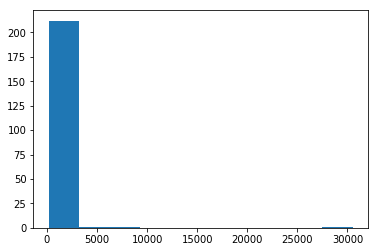

In [22]:

plt.hist(sf.duration_sec[(sf.start_station_id == 13) & (sf.end_station_id == 19)])

In [23]:
# sf['avg_duration'] = 1
# sf

In [24]:
sf[(sf.year == 2018) & (sf.month == 6)]

,Unnamed: 0,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,day_of_week,date,year,month,day,hour,malfunction,age,Female,Male,Other
461850,0,59088,2018-06-30 23:32:44.659,2018-07-01 15:57:33.3160,76.0,McCoppin St at Valencia St,37.771662,-122.422423,95.0,Sanchez St at 15th St,37.766219,-122.431060,2100,Subscriber,1975.0,Male,Yes,5,2018-06-30,2018,6,30,23,False,44.0,0,1,0
461851,2,63654,2018-06-30 20:26:53.031,2018-07-01 14:07:47.2320,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,50.0,2nd St at Townsend St,37.780526,-122.390288,3235,Subscriber,1962.0,Female,No,5,2018-06-30,2018,6,30,20,False,57.0,0,1,0
461852,3,50508,2018-06-30 20:29:59.813,2018-07-01 10:31:48.2500,58.0,Market St at 10th St,37.776619,-122.417385,88.0,11th St at Bryant St,37.770030,-122.411726,3675,Subscriber,1992.0,Male,No,5,2018-06-30,2018,6,30,20,False,27.0,0,1,0
461853,5,36708,2018-06-30 20:25:34.225,2018-07-01 06:37:22.5950,8.0,The Embarcadero at Vallejo St,37.799953,-122.398525,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,577,Customer,NaN,NaN,No,5,2018-06-30,2018,6,30,20,False,NaN,0,1,0
461854,7,7224,2018-06-30 23:01:00.400,2018-07-01 01:01:24.4330,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,779,Subscriber,1989.0,Male,No,5,2018-06-30,2018,6,30,23,False,30.0,0,1,0
461855,9,2209,2018-06-30 23:55:13.210,2018-07-01 00:32:02.3040,133.0,Valencia St at 22nd St,37.755213,-122.420975,55.0,Webster St at Grove St,37.777053,-122.429558,4225,Subscriber,1963.0,Male,Yes,5,2018-06-30,2018,6,30,23,False,56.0,1,0,0
461856,10,8975,2018-06-30 21:56:30.967,2018-07-01 00:26:06.7180,75.0,Market St at Franklin St,37.773793,-122.421239,75.0,Market St at Franklin St,37.773793,-122.421239,3972,Subscriber,1981.0,Male,No,5,2018-06-30,2018,6,30,21,False,38.0,0,1,0
461857,11,7256,2018-06-30 22:17:03.129,2018-07-01 00:17:59.7970,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3369,Customer,1990.0,Male,No,5,2018-06-30,2018,6,30,22,False,29.0,0,1,0
461858,15,1740,2018-06-30 23:41:17.541,2018-07-01 00:10:17.9430,10.0,Washington St at Kearny St,37.795393,-122.404770,73.0,Pierce St at Haight St,37.771793,-122.433708,4009,Customer,1986.0,Male,No,5,2018-06-30,2018,6,30,23,False,33.0,0,1,0
461859,16,1842,2018-06-30 23:39:28.777,2018-07-01 00:10:11.1030,10.0,Washington St at Kearny St,37.795393,-122.404770,73.0,Pierce St at Haight St,37.771793,-122.433708,3953,Customer,1986.0,Male,No,5,2018-06-30,2018,6,30,23,False,33.0,0,1,0


In [25]:
def month_sep(df, year, month):
    return df[(df.year == 2017) & (df.month == 6)]

In [26]:
dtDate = datetime(2016,1,1,0,0)

print (dtDate - pd.DateOffset(months=3))

2015-10-01 00:00:00


### Station count

In [16]:
def num_trips_label(df):
    cdf =pd.DataFrame(df.start_station_id.value_counts())
    cdf = cdf.reset_index()
    cdf.columns = ['start_station_id', 'num_trips']
    return pd.merge(df, cdf, on='start_station_id', how='left')

In [17]:
sf = num_trips_label(sf)

In [18]:
sf.head(2)

,Unnamed: 0,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,day_of_week,date,year,month,day,hour,malfunction,age,Female,Male,Other,num_trips
0,0,75284,2018-01-31 22:52:35.239,2018-02-01 19:47:19.8240,120.0,Mission Dolores Park,37.761420,-122.426435,285.0,Webster St at O'Farrell St,37.783521,-122.431158,2765,Subscriber,1986.0,Male,No,2,2018-01-31,2018,1,31,22,False,33.0,0,1,0,9059
1,1,85422,2018-01-31 16:13:34.351,2018-02-01 15:57:17.3100,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,2815,Customer,NaN,NaN,No,2,2018-01-31,2018,1,31,16,False,NaN,0,0,0,44283


### removing outliers Using IQR -/+ 1.5

In [19]:
#duration_sec for station combo 13 and 19
dur = np.array(sf[(sf.start_station_id == 13) & (sf.end_station_id == 19)]['duration_sec'])

In [20]:
#Q3
q3 = np.percentile(np.sort(dur), 75)

In [21]:
#Q1
q1 = np.percentile(np.sort(dur), 25)

In [22]:
IQR = scs.iqr(np.sort(dur))

In [23]:
#lower bound
lb = q1 - (IQR*1.5)
ub = q3 + (IQR*1.5)
lb, ub

(-37.0, 703.0)

In [24]:
def rmv_outliers_iqr(df):
    for s in unique_start_sations:
        for e in unique_end_stations:
            dur = np.sort(np.array(sf[(sf.start_station_id == s) & (sf.end_station_id == e)]['duration_sec']))
            #Q3
            q3 = np.percentile(dur, 75)
            #Q1
            q1 = np.percentile(dur, 25)
            #IQR
            IQR = scs.iqr(dur)

            #lower bound
            lb = q1 - (IQR*1.5)
            ub = q3 + (IQR*1.5)
    

    
    

### calculating average for similar trips

In [25]:
#avg time for similar trips
#for example
#trips start at station 13
#ending with station 19
# sf['avg_duration'][(sf.start_station_id == 13) & (sf.end_station_id == 19)] = sf[(sf.start_station_id == 13) & (sf.end_station_id == 19)]['duration_sec'].mean()
avg_time_arr = np.zeros([1,3])
for s in unique_start_sations:
    for e in unique_end_stations:
        avg_time = sf[(sf.start_station_id == s) & (sf.end_station_id == e)]['duration_sec'].mean()
        b = np.array([s,e,avg_time])
        avg_time_arr = np.vstack((avg_time_arr, b))

KeyboardInterrupt: 

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
avg_time_df = pd.DataFrame(avg_time_arr[1:])

In [ ]:
avg_time_df.columns= ['start_station_id', 'end_station_id', 'avg_time_sec']

In [ ]:
avg_time_df.head(2)

In [ ]:
sf.head(5)

In [ ]:
sf = pd.merge(sf, avg_time_df, on=['start_station_id','end_station_id'], how='left')

In [ ]:
# master = merge_dfs(sf, weather)

In [ ]:
#check to see if there are any columns with NaN values
#if there are any, append it to a list for now
# columns_w_NaN = []
# for c in list(master.columns.values):
#     if master[c].isna().any():
#         columns_w_NaN.append(c)

In [ ]:
# master.member_birth_year.isna().sum()

In [ ]:
# master.head(2)

In [ ]:
#exploring the distribution of end stations given a start station


### Remove NaN values

In [26]:
c_df = merge_dfs(sf, weather)
c_df = c_df[c_df.member_birth_year.isna() == False]

In [27]:
c_df.user_type = c_df.user_type.replace({'Subscriber': 1, "Customer" : 0})

### Predicting the count of a bike trip

In [ ]:
X = c_df[['start_station_id', 'hour','day_of_week','tavg', 'prcp']]
y = c_df['num_trips']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
lr.get_params()
lr.score(X_test, y_test)

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
cross_val_score(clf, X_train,y_train)

In [ ]:
c_df.head(2)

## Identifying the 3 nearest stations
### this will be my new label

In [28]:
#identifying the 3 closest stations using knn
#to store:
#create a dictionary with 
#key = station id
#values = list of the 3 closest stations

In [29]:
# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=3)


In [30]:

def euclidean_distance(x, y):
    return np.sqrt(((x-y)**2).sum(axis=1))

In [31]:
#getting the coordinates from the dataset
coordinates = np.array(c_df[['end_station_longitude', 'end_station_latitude']])
coordinates

array([[-122.43115783,   37.78352084],
       [-122.403452  ,   37.788975  ],
       [-122.4206278 ,   37.7524278 ],
       ...,
       [-122.40853071,   37.78829998],
       [-122.39274083,   37.77874161],
       [-122.39593562,   37.78499973]])

In [32]:
#return only the unique coordinates
unique_coords = np.unique(coordinates, axis = 0)
unique_coords

array([[-122.473658  ,   37.771104  ],
       [-122.45370448,   37.77191688],
       [-122.45309293,   37.77610091],
       [-122.44729131,   37.77904666],
       [-122.44654566,   37.77483629],
       [-122.4442926 ,   37.77331088],
       [-122.4418376 ,   37.7774157 ],
       [-122.43944585,   37.7824046 ],
       [-122.4390777 ,   37.7730627 ],
       [-122.4377775 ,   37.775946  ],
       [-122.4369431 ,   37.7591769 ],
       [-122.4368608 ,   37.7789994 ],
       [-122.4356498 ,   37.772406  ],
       [-122.43455887,   37.78381271],
       [-122.4339496 ,   37.750506  ],
       [-122.4338119 ,   37.7692005 ],
       [-122.4337079 ,   37.7717933 ],
       [-122.43327409,   37.77754677],
       [-122.4326417 ,   37.7610471 ],
       [-122.4319464 ,   37.78045006],
       [-122.4318042 ,   37.764285  ],
       [-122.43115783,   37.78352084],
       [-122.4310597 ,   37.7662185 ],
       [-122.4306746 ,   37.7632417 ],
       [-122.4295585 ,   37.7770527 ],
       [-122.4291557 ,   

In [33]:
#create a dictionary with
#station id as key
#coordinates for the station id as values
id_coord = {}
for u in unique_coords:
    k = c_df.end_station_id[(c_df.end_station_longitude == u[0]) &(c_df.end_station_latitude == u[1])].iloc[0]
    id_coord[k] = u

id_coord

{367.0: array([-122.473658,   37.771104]),
 377.0: array([-122.45370448,   37.77191688]),
 51.0: array([-122.45309293,   37.77610091]),
 380.0: array([-122.44729131,   37.77904666]),
 375.0: array([-122.44654566,   37.77483629]),
 70.0: array([-122.4442926 ,   37.77331088]),
 52.0: array([-122.4418376,   37.7774157]),
 29.0: array([-122.43944585,   37.7824046 ]),
 71.0: array([-122.4390777,   37.7730627]),
 53.0: array([-122.4377775,   37.775946 ]),
 118.0: array([-122.4369431,   37.7591769]),
 39.0: array([-122.4368608,   37.7789994]),
 72.0: array([-122.4356498,   37.772406 ]),
 31.0: array([-122.43455887,   37.78381271]),
 137.0: array([-122.4339496,   37.750506 ]),
 84.0: array([-122.4338119,   37.7692005]),
 73.0: array([-122.4337079,   37.7717933]),
 54.0: array([-122.43327409,   37.77754677]),
 119.0: array([-122.4326417,   37.7610471]),
 365.0: array([-122.4319464 ,   37.78045006]),
 105.0: array([-122.4318042,   37.764285 ]),
 285.0: array([-122.43115783,   37.78352084]),
 95.

In [34]:
t = 59
#the coordinate for the station in the t-th position
trgt_station = unique_coords[t]

In [35]:
#n closest neighbors for the station in the t-th position
n=3
neighbors = unique_coords[np.argsort(euclidean_distance(trgt_station, unique_coords))][0:n]

In [36]:
#target station id #
# sf.end_station_id[(sf.end_station_longitude == trgt_station[0]) &(sf.end_station_latitude == trgt_station[1])].iloc[0]


In [37]:
neighbors

array([[-122.418892 ,   37.760299 ],
       [-122.4213392,   37.7592103],
       [-122.4148171,   37.7605936]])

In [38]:
#getting the knn station id #s
for i in range(n):
    knn_id = c_df.end_station_id[(c_df.end_station_longitude == neighbors[i][0]) &(c_df.end_station_latitude == neighbors[i][1])].iloc[0]
    print(knn_id)

122.0
121.0
123.0


In [39]:
knn_dict = {}
for tu in unique_coords:
    neighbors = unique_coords[np.argsort(euclidean_distance(tu, unique_coords))][1:4]
    k = c_df.end_station_id[(c_df.end_station_longitude == tu[0]) &(c_df.end_station_latitude == tu[1])].iloc[0]
    v = [k]
    for i in range(n):
        knn_id = c_df.end_station_id[(c_df.end_station_longitude == neighbors[i][0]) &(c_df.end_station_latitude == neighbors[i][1])].iloc[0]
        v.append(knn_id)
    knn_dict[k] = v
knn_dict

{367.0: [367.0, 377.0, 51.0, 375.0],
 377.0: [377.0, 51.0, 375.0, 70.0],
 51.0: [51.0, 377.0, 380.0, 375.0],
 380.0: [380.0, 375.0, 52.0, 70.0],
 375.0: [375.0, 70.0, 380.0, 52.0],
 70.0: [70.0, 375.0, 52.0, 71.0],
 52.0: [52.0, 53.0, 70.0, 71.0],
 29.0: [29.0, 39.0, 31.0, 52.0],
 71.0: [71.0, 53.0, 72.0, 52.0],
 53.0: [53.0, 71.0, 39.0, 72.0],
 118.0: [118.0, 119.0, 105.0, 106.0],
 39.0: [39.0, 53.0, 54.0, 29.0],
 72.0: [72.0, 73.0, 71.0, 84.0],
 31.0: [31.0, 285.0, 365.0, 29.0],
 137.0: [137.0, 138.0, 132.0, 118.0],
 84.0: [84.0, 73.0, 72.0, 95.0],
 73.0: [73.0, 72.0, 84.0, 85.0],
 54.0: [54.0, 365.0, 55.0, 39.0],
 119.0: [119.0, 106.0, 105.0, 118.0],
 365.0: [365.0, 285.0, 54.0, 55.0],
 105.0: [105.0, 106.0, 95.0, 119.0],
 285.0: [285.0, 365.0, 31.0, 40.0],
 95.0: [95.0, 105.0, 106.0, 84.0],
 106.0: [106.0, 105.0, 119.0, 95.0],
 55.0: [55.0, 74.0, 40.0, 54.0],
 85.0: [85.0, 86.0, 56.0, 95.0],
 138.0: [138.0, 132.0, 140.0, 131.0],
 56.0: [56.0, 74.0, 85.0, 86.0],
 40.0: [40.0, 74.0, 

## Visualize stations

In [27]:
print("The origin station is {}.".format(t))
print("The 3 closest neighbors are: {}, {}, {}".format(int(knn_dict.get(t)[0]),int(knn_dict.get(t)[1]),int(knn_dict.get(t)[2])))
plt.figure(figsize = (10,10))
ll,rr = -122.50, -122.36
bb = 37.73
plt.xlim(ll,rr)
plt.ylim(bb, bb+(rr-ll))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Map of Ford GoBike stations in San Francisco")
plt.scatter(c_df.end_station_longitude, c_df.end_station_latitude, s=1, c=('r'))
plt.scatter(id_coord.get(t)[0], id_coord.get(t)[1], s=20, marker='x', c=('b'))

for st in knn_dict.get(t):
    plt.scatter(id_coord.get(st)[0],id_coord.get(st)[1], s= 10, c='g')
plt.show()



NameError: name 't' is not defined

In [41]:
for st in knn_dict.get(t):
    print(id_coord.get(st))

[-122.418954   37.774814]
[-122.417385   37.776619]
[-122.42123902   37.77379321]
[-122.4160402   37.7735069]


## Adding knn to df

In [ ]:
c_df.head(2)

In [ ]:
knn_dict

In [ ]:
dict_df = pd.DataFrame(pd.Series(knn_dict).reset_index()).set_axis(['Key','Value'],1,inplace=False)
                                                                       

In [ ]:
dict_df.columns = ['end_station_id', 'neighbor_stations']

In [ ]:
labeled_df = pd.merge(c_df, dict_df, on ='end_station_id', how='left')

In [ ]:
labeled_df.info()

In [ ]:
labeled_df

In [ ]:
type(labeled_df.start_time)

## Trends






In [ ]:
#number of trips for each hour
for station in unique_end_stations:
    plt.xlabel("hour")
    plt.ylabel("trips")
    plt.title("Station: {}".format(station))
    plt.hist(labeled_df[labeled_df.end_station_id == station].hour, bins = 24)
    plt.show()

In [ ]:
#number of trips per day of week
plt.hist(labeled_df.day_of_week, bins = 7)

In [ ]:
#number of trips for a given temperature
plt.hist(labeled_df.tavg)

In [ ]:
#most popular station
plt.hist(labeled_df.end_station_id, bins = int(150))

### First iteration

In [ ]:
# X = labeled_df[['duration_sec', 'start_station_id', 'hour', 'day_of_week']]
# y = labeled_df.end_station_id
# # had mean cross val score of 0.136

### Second Iteration

In [ ]:
# X = labeled_df[['start_station_id', "day_of_week", "hour","tavg"]]
# y = labeled_df['end_station_id']
#used own scoring system with knn = 2 and received a score of 0.149

In [ ]:
hour_df = labeled_df
X = hour_df[['duration_sec','start_station_id', 'prcp',"day_of_week", "hour","tavg","Female", "age", "user_type"]]
y = hour_df['end_station_id']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#using random forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)

In [ ]:
y_test = y_test.reset_index()

In [ ]:
score = 0
for pre in range(predictions.shape[0]):
    if np.array(y_test)[pre][1] in knn_dict.get(predictions[pre]):
        score+=1

In [ ]:
score/predictions.shape[0]

## Which hour generated the best accuracy score?

In [ ]:
def hour_scores(df):
    hour_scores = {}
    for h in range(24):
        hour_df = labeled_df[labeled_df.hour == h]
        X = hour_df[['start_station_id', 'prcp',"day_of_week","tavg"]]
        y = hour_df['end_station_id']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        #using random forest
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        y_test = y_test.reset_index()
        score = 0
        for pre in range(predictions.shape[0]):
            if np.array(y_test)[pre][1] in knn_dict.get(predictions[pre]):
                score+=1
        accuracy = score/predictions.shape[0]
        hour_scores[h] = accuracy
    return hour_scores, hour_df

In [ ]:
accuracy_hour, hour_df= hour_scores(labeled_df)

In [ ]:
def plt_scores(scores):
    plt.xlabel("hour")
    plt.ylabel("score")
    plt.title("Accuracy for each hour")
    for k, v in scores.items():
        plt.scatter(k,v, c='g')
    plt.show()

In [ ]:
plt_scores(accuracy_hour)

In [ ]:
scoring = pd.DataFrame(np.hstack((predictions.reshape(-1,1), np.array(actual)[:,1].reshape(-1,1))))

In [ ]:
#mean score using random forest
# mean_score = cross_val_score(clf,X_test, y_test ).mean()

In [ ]:
mean_score

In [ ]:
master.head(2)

In [ ]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50, 50, 50), random_state=1)
mlpc.fit(X_train, y_train)     

In [ ]:
mlpc.predict(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train[['duration_sec', 'start_station_id', 'tavg']], y_train)

In [ ]:
predictions = lr.predict(X_test[['duration_sec', 'start_station_id', 'tavg']])

In [ ]:
a = np.array(y_test).reshape(-1,1)
type(p)

In [ ]:
p = predictions.reshape(-1,1)
p.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier()
clf.fit(X_train[['duration_sec', 'start_station_id', 'tavg']], y_train)

In [ ]:
rf_predictions = clf.predict(X_test[['duration_sec', 'start_station_id', 'tavg']]).reshape(-1,1)

In [ ]:
str(y[0])

In [ ]:
type(weather.date[0])

In [ ]:

sfi = sf.set_index(sf.date)
weatheri = weather.set_index(weather.date)

In [ ]:
weather.head(5)

In [ ]:
concat_index = pd.concat([sfi, weatheri], axis=1, join_axes=[sfi.index])


In [ ]:
def rf_score(df):
    X = df[['start_station_id', 'tavg', 'hour', 'day_of_week']]
    y = df.end_station_id


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)   
    mean_score = cross_val_score(clf,X_test, y_test ).mean()
    return mean_score

In [ ]:
rf_score(master)

## MVP

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


pd.options.display.max_columns = None

In [ ]:
trips = pd.read_csv("data/201812-fordgobike-tripdata.csv")
weather = pd.read_csv('data/weather.csv')

In [ ]:
def feature_addition(df):
    '''
    INPUT dataframe
    OUTPUT dataframe with extra features
    '''
    #create a new column that shows the day of week for each trip
    #need to transform panda series to datetime
    #before we can use .dt.dayofweek
    #monday = 0 and sunday = 6

    df.start_time = pd.to_datetime(df.start_time)

    df['day_of_week'] = df.start_time.dt.dayofweek

    df['date'] = df.start_time.dt.date
    df['hour'] = df.start_time.dt.hour

    #any trip with less than 90 seconds and where
    #start station IS the end station,
    #we make the assumption that its malfunctioned
    df['malfunction'] = (df.duration_sec < 90) & (df.start_station_name == df.end_station_name)
    df['age'] = 2019 - df.member_birth_year

    return df

def model_city(df, city = 1):
    '''
    Breaks the dataset into 3 cities
    SF = 1
    OAK = 2
    SJ = 3

    INPUT: Dataframe
           Number for city to be modeled
    OUTPUT: returns a portion of the original dataframe
    ''' 
    if city == 1:
        return df[(df.end_station_latitude > 37.697799) & (df.end_station_longitude <-122.330676)]
    elif city == 2:
        return df[(df.end_station_latitude > 37.697799) & (df.end_station_longitude >-122.330676)]
    elif city == 3:
        return df[df.end_station_latitude < 37.697799]
    
    
def merge_dfs(df1, df2, column = 'date'):
    '''
    INPUT df1 is the trips dataframe
          df2 is the weather dataframe
    OUTPUT 1 combined dataframe
    '''
    df2['tavg'] = (df2.tmax + df2.tmin)/2
    df2[column] = pd.to_datetime(df2[column])
    df2[column] = df2[column].dt.date
    combined_df = pd.merge(df1,df2, on='date', how='left')
    return combined_df

In [ ]:
#include day_of_week, date, hour, user_age into dataframe
df = feature_addition(trips)
#filter out the dataset for SF stations only
sf = model_city(df,1).reset_index()
sf.drop(['index'], axis = 1, inplace = True)
weather.columns = map(str.lower, weather.columns)

In [ ]:
#merge the sf and weather dataset
c_df = merge_dfs(sf, weather)
#remove datapoints with no birth year
c_df = c_df[c_df.member_birth_year.isna() == False]

In [ ]:

def euclidean_distance(x, y):
    return np.sqrt(((x-y)**2).sum(axis=1))

In [ ]:
#getting the coordinates from the dataset
coordinates = np.array(c_df[['end_station_longitude', 'end_station_latitude']])

In [ ]:
#return only the unique coordinates
unique_coords = np.unique(coordinates, axis = 0)

In [ ]:
#n closest neighbors for the station in the t-th position
n=3

In [ ]:
#create a dictionary with
#origin station id as key
#knn station ids as values
knn_dict = {}
for tu in unique_coords:
    neighbors = unique_coords[np.argsort(euclidean_distance(tu, unique_coords))][1:4]
    k = c_df.end_station_id[(c_df.end_station_longitude == tu[0]) &(c_df.end_station_latitude == tu[1])].iloc[0]
    v = [k]
    for i in range(n):
        knn_id = c_df.end_station_id[(c_df.end_station_longitude == neighbors[i][0]) &(c_df.end_station_latitude == neighbors[i][1])].iloc[0]
        v.append(knn_id)
    knn_dict[k] = v

In [ ]:
dict_df = pd.DataFrame(pd.Series(knn_dict).reset_index()).set_axis(['Key','Value'],1,inplace=False)
                                                                       

In [ ]:
dict_df.columns = ['end_station_id', 'neighbor_stations']

In [ ]:
labeled_df = pd.merge(c_df, dict_df, on ='end_station_id', how='left')

In [ ]:
X = labeled_df[['start_station_id', "day_of_week", "hour","tavg"]]
y = labeled_df['end_station_id']

In [ ]:

#using random forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)


In [ ]:
y_test = y_test.reset_index()

In [ ]:
score = 0
for pre in range(predictions.shape[0]):
    if np.array(y_test)[pre][1] in knn_dict.get(predictions[pre]):
        score+=1

In [ ]:
score/predictions.shape[0]